# Projet 2 : Estimation du SOC par Intelligence Artificielle - Modèle LSTM

Ce notebook implémente un réseau de neurones **Long Short-Term Memory (LSTM)** pour estimer le State of Charge (SOC) d'une batterie. Les LSTM sont particulièrement adaptés pour capturer la dynamique temporelle (hystérésis, historique).

## Objectifs
1. Chargement et analyse des données.
2. Prétraitement spécifique (Séquences temporelles 3D).
3. Construction et entraînement du modèle LSTM.
4. Évaluation des performances (MAE, RMSE, R²).

In [1]:
# Installation plus robuste des bibliothèques nécessaires
import sys
!{sys.executable} -m pip install tensorflow pandas numpy matplotlib seaborn scikit-learn

print("Installation terminée. SI C'EST LA PREMIÈRE FOIS, VEUILLEZ REDÉMARRER LE NOYAU (KERNEL -> RESTART) avant d'exécuter la suite.")

Installation terminée. SI C'EST LA PREMIÈRE FOIS, VEUILLEZ REDÉMARRER LE NOYAU (KERNEL -> RESTART) avant d'exécuter la suite.


## 1. Importations et Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import os

# Vérification GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

c:\Users\amendiglembaye\AppData\Local\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
Num GPUs Available:  0


## 2. Chargement des Données

In [3]:
# Chemin du fichier (à adapter selon votre environnement, ex: '/content/drive/My Drive/...')
file_path = 'battery_data_csv_forEstimation.csv'

# Si utilisation sur Colab, décommentez les lignes suivantes pour uploader ou mounter
# from google.colab import drive
# drive.mount('/content/drive')

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Données chargées. Taille: {df.shape}")
else:
    print("Erreur : Fichier non trouvé.")

Données chargées. Taille: (145460, 4)


## 3. Prétraitement pour LSTM
Le LSTM attend une entrée de forme `(samples, time_steps, features)`.
Nous devons transformer nos données tabulaires 2D en séquences 3D.

- **Normalisation** : Essentielle pour aider le gradient à converger.
- **Sliding Window (Fenêtre Glissante)** : Nous créons des séquences de longueur `LOOK_BACK` pour prédire l'instant `t+1` (ou `t`).

In [4]:
# Sélection des features
features_cols = ['Current', 'Voltage', 'Temperature']
target_col = 'SOC'

data_values = df[features_cols + [target_col]].values

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

print("Aperçu des données normalisées :", data_scaled[:5])

Aperçu des données normalisées : [[0.9989646  0.79775435 0.09447256 0.09174272]
 [0.99888681 0.79787954 0.09427769 0.09195599]
 [0.99880902 0.79800472 0.09408282 0.09216921]
 [0.99873123 0.79812991 0.09388795 0.09238236]
 [0.99879093 0.79825223 0.09375966 0.09259545]]


In [5]:
def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        # Features : Colonnes 0, 1, 2 sur la fenêtre temporelle
        a = dataset[i:(i + look_back), 0:3]
        X.append(a)
        # Target : Colonne 3 (SOC) à l'instant t (fin de la fenêtre)
        Y.append(dataset[i + look_back, 3])
    return np.array(X), np.array(Y)

# Configuration de la séquence
# Une fenêtre plus grande permet de capturer plus de dynamique (long terme)
LOOK_BACK = 50 

X, Y = create_dataset_lstm(data_scaled, LOOK_BACK)

# Forme attendue par LSTM [samples, time_steps, features]
print("Shape X (LSTM input) :", X.shape)
print("Shape Y (Target) :", Y.shape)

Shape X (LSTM input) : (145410, 50, 3)
Shape Y (Target) : (145410,)


In [6]:
# Split Train/Val/Test (70% Train, 15% Val, 15% Test)
total_len = len(X)
train_len = int(total_len * 0.7)
val_len = int(total_len * 0.15)

X_train, Y_train = X[:train_len], Y[:train_len]
X_val, Y_val = X[train_len:train_len+val_len], Y[train_len:train_len+val_len]
X_test, Y_test = X[train_len+val_len:], Y[train_len+val_len:]

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Train: (101787, 50, 3)
Val:   (21811, 50, 3)
Test:  (21812, 50, 3)


## 4. Construction et Entraînement du Modèle LSTM

In [7]:
def build_lstm_model(input_shape):
    model = Sequential()
    # Première couche LSTM avec retour de séquence pour empiler une autre couche LSTM
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Seconde couche LSTM
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Couche Dense pour la sortie
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # ACTIVATION SIGMOID : Plus précis pour atteindre les min/max (0 et 1) que sigmoid
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2]) # (time_steps, features)
model_lstm = build_lstm_model(input_shape)
model_lstm.summary()

c:\Users\amendiglembaye\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entraînement
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=50, # 50 Époques
    batch_size=64,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 89s 54ms/step - loss: 0.0047 - mae: 0.0415 - val_loss: 0.0190 - val_mae: 0.1129
Epoch 2/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 75s 47ms/step - loss: 5.7709e-04 - mae: 0.0179 - val_loss: 0.0258 - val_mae: 0.1149
Epoch 3/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - loss: 3.4468e-04 - mae: 0.0138 - val_loss: 0.0290 - val_mae: 0.1124
Epoch 4/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - loss: 2.5399e-04 - mae: 0.0117 - val_loss: 0.0314 - val_mae: 0.1218
Epoch 5/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - loss: 1.8609e-04 - mae: 0.0100 - val_loss: 0.0290 - val_mae: 0.1380
Epoch 6/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - loss: 1.4995e-04 - mae: 0.0089 - val_loss: 0.0229 - val_mae: 0.1139
Epoch 7/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - loss: 1.2949e-04 - mae: 0.0083 - val_loss: 0.0191 - val_mae: 0.1103
Epoch 8/20
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - loss: 1.1573e-04 - mae: 0.0078 - val_loss: 0.0158 - val_mae: 0.

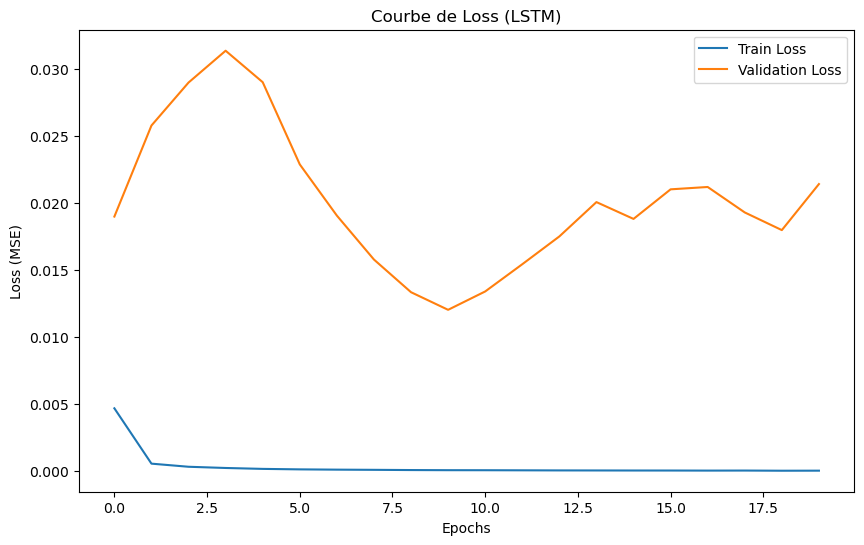

In [9]:
# Visualisation de la Loss
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## 5. Évaluation et Résultats

In [10]:
# Prédictions
predictions_lstm = model_lstm.predict(X_test)

# Calcul des métriques
mae_lstm = mean_absolute_error(Y_test, predictions_lstm)
rmse_lstm = math.sqrt(mean_squared_error(Y_test, predictions_lstm))
r2_lstm = r2_score(Y_test, predictions_lstm)

print(f"LSTM MAE: {mae_lstm:.4f}")
print(f"LSTM RMSE: {rmse_lstm:.4f}")
print(f"LSTM R²: {r2_lstm:.4f}")

682/682 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
LSTM MAE: 0.1041
LSTM RMSE: 0.1163
LSTM R²: 0.8536


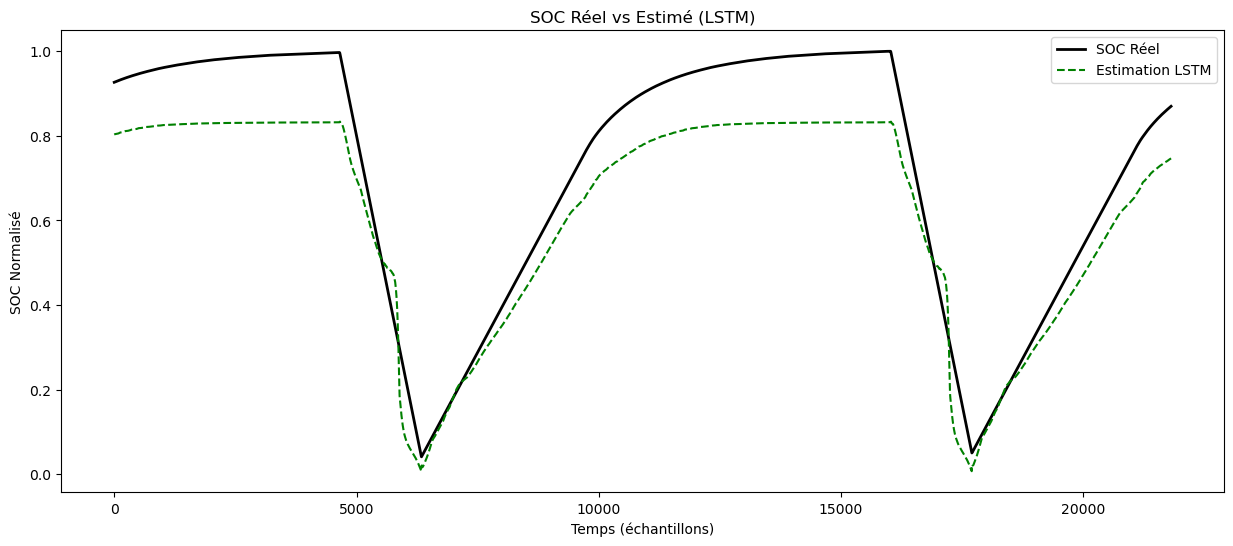

In [11]:
# Comparaison Graphique
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label='SOC Réel', color='black', linewidth=2)
plt.plot(predictions_lstm, label='Estimation LSTM', color='green', linestyle='--')
plt.title('SOC Réel vs Estimé (LSTM)')
plt.xlabel('Temps (échantillons)')
plt.ylabel('SOC Normalisé')
plt.legend()
plt.show()

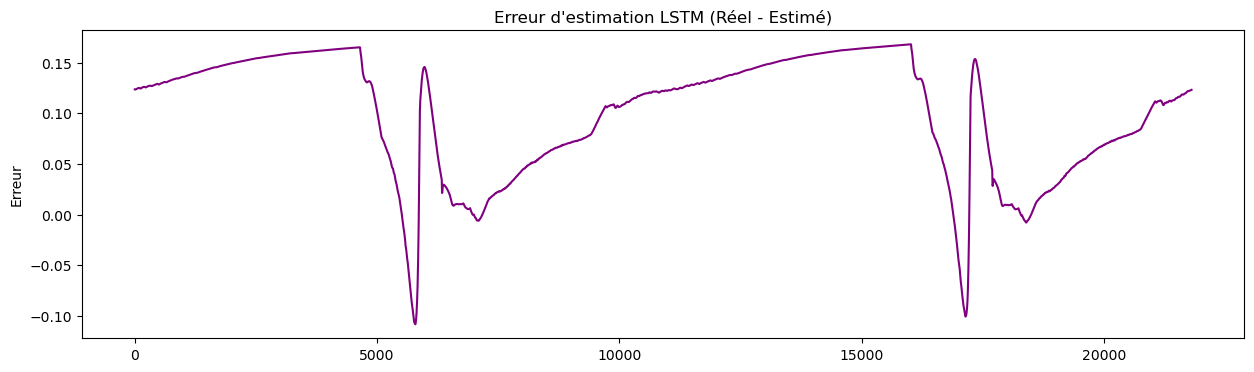

In [12]:
# Erreur d'estimation
error_lstm = Y_test - predictions_lstm.flatten()
plt.figure(figsize=(15, 4))
plt.plot(error_lstm, color='purple')
plt.title("Erreur d'estimation LSTM (Réel - Estimé)")
plt.ylabel('Erreur')
plt.show()

In [13]:
# Sauvegarde
model_lstm.save('lstm_soc_model.h5')
print("Modèle LSTM sauvegardé.")

Modèle LSTM sauvegardé.
